Notebook 01 — Exploratory Data Analysis (EDA) | Texas Utility Prospecting

Objetivo del EDA

Entender el mercado de utilities en Texas: quiénes están, cuánta cobertura tienen por ZIP y qué tipo de ownership predomina.

Entender la infraestructura: dónde hay más subestaciones (proxy de infraestructura eléctrica).

Preparar los datos con una limpieza mínima para evitar conclusiones falsas en métricas y gráficos.

CARGAR DATOS

In [1]:
import pandas as pd
import numpy as np

# Utilities TX (ya filtrado en Notebook 00)
df_tx = pd.read_csv(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\data\processed\utilities_tx.csv")

# Substations (raw) y filtramos TX acá
df_sub = pd.read_csv(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\data\raw\US Electric Power Transmission Substations.csv")

print("Utilities TX:", df_tx.shape)
print("Substations raw:", df_sub.shape)


Utilities TX: (3085, 10)
Substations raw: (79687, 26)


C:\Users\palmi\AppData\Local\Temp\ipykernel_9752\1491561851.py:8: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sub = pd.read_csv(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\data\raw\US Electric Power Transmission Substations.csv")


Limpieza aplicada

ZIP como texto de 5 dígitos: si ZIP queda como número, puede perder ceros a la izquierda y rompe agrupaciones/joins.

utility_name sin espacios al inicio/fin: “El Paso Electric Co” y “El Paso Electric Co ” se contarían como dos empresas distintas.

Rates como numéricos y tratar 0 como faltante (solo para análisis de promedios): en datasets de tarifas, el 0 muchas veces aparece como “dato no reportado”. Si lo dejamos, baja artificialmente los promedios y distorsiona insights.
📌 Lo convertimos a NaN para que pandas lo ignore en promedios.

LAT/LON numéricos y sin nulos (subestaciones): si hay coordenadas vacías o texto, el mapa falla o queda mal.

In [ ]:
# 1) ZIP siempre como string de 5 dígitos
df_tx["zip"] = (
    df_tx["zip"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .str.zfill(5)
)

# 2) Limpiar nombre utility
df_tx["utility_name"] = df_tx["utility_name"].astype(str).str.strip()

# 3) Rates: convertir a numéricos y reemplazar 0 por NaN (para no distorsionar promedios)
rate_cols = ["comm_rate", "ind_rate", "res_rate"]
for c in rate_cols:
    df_tx[c] = pd.to_numeric(df_tx[c], errors="coerce")

# Chequeo de ceros antes de reemplazar (para documentar)
zeros_before = (df_tx[rate_cols] == 0).sum()

# Reemplazo 0 -> NaN (solo para EDA/estadísticas)
df_tx[rate_cols] = df_tx[rate_cols].replace(0, np.nan)

# 4) Substations: filtrar TX + lat/lon numéricos
df_sub_tx = df_sub[df_sub["STATE"].astype(str).str.upper().str.strip() == "TX"].copy()

df_sub_tx["LATITUDE"] = pd.to_numeric(df_sub_tx["LATITUDE"], errors="coerce")
df_sub_tx["LONGITUDE"] = pd.to_numeric(df_sub_tx["LONGITUDE"], errors="coerce")

# Quitar filas sin coordenadas (necesarias para mapa)
df_sub_tx = df_sub_tx.dropna(subset=["LATITUDE", "LONGITUDE"])

print("✅ Zeros en rates (antes de reemplazar):")
print(zeros_before)

print("\nUtilities TX (limpio):", df_tx.shape)
print("Substations TX (limpio):", df_sub_tx.shape)


✅ Zeros en rates (antes de reemplazar):
comm_rate      3
ind_rate     314
res_rate       0
dtype: int64

Utilities TX (limpio): (3085, 10)
Substations TX (limpio): (5314, 26)


VISTA GENERAL DEL DATASET

In [3]:
df_tx.head()


,zip,eiaid,utility_name,state,service_type,ownership,comm_rate,ind_rate,res_rate,utility_type
0,79932,5701,El Paso Electric Co,TX,Bundled,Investor Owned,0.08918,0.046611,0.120553,IOU
1,79903,5701,El Paso Electric Co,TX,Bundled,Investor Owned,0.08918,0.046611,0.120553,IOU
2,79906,5701,El Paso Electric Co,TX,Bundled,Investor Owned,0.08918,0.046611,0.120553,IOU
3,79901,5701,El Paso Electric Co,TX,Bundled,Investor Owned,0.08918,0.046611,0.120553,IOU
4,79851,5701,El Paso Electric Co,TX,Bundled,Investor Owned,0.08918,0.046611,0.120553,IOU


In [4]:
df_tx["state"].value_counts().head()


state
TX    3085
Name: count, dtype: int64

In [5]:
df_tx["zip"].str.len().value_counts().head()


zip
5    3085
Name: count, dtype: int64

TOP 20 UTILITIES POR CANTIDAD DE ZIP

In [6]:
top_utils = (
    df_tx.groupby("utility_name")["zip"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
    .reset_index(name="n_zips")
)

top_utils


,utility_name,n_zips
0,Entergy Texas Inc.,242
1,Southwestern Public Service Co,159
2,"TXU Energy Retail Co, LLC",154
3,El Paso Electric Co,148
4,Southwestern Electric Power Co,147
5,Heart of Texas Electric Coop,132
6,City of San Antonio - (TX),117
7,Reliant Energy Retail Services,102
8,"Bartlett Electric Coop, Inc",97
9,"Pedernales Electric Coop, Inc",86


GRAFICO TOP UTILITIES

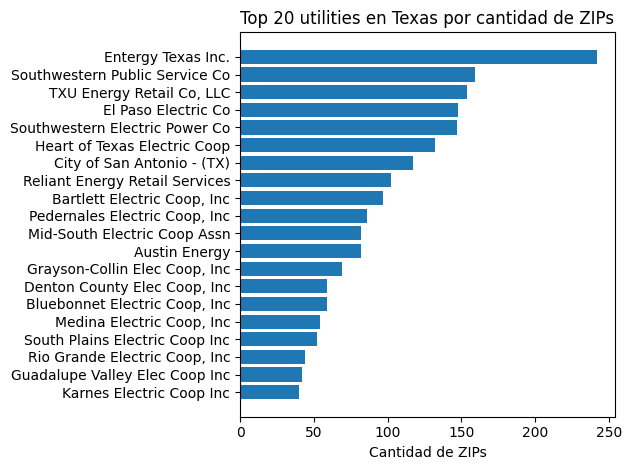

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(top_utils["utility_name"][::-1], top_utils["n_zips"][::-1])
plt.title("Top 20 utilities en Texas por cantidad de ZIPs")
plt.xlabel("Cantidad de ZIPs")
plt.tight_layout()
plt.show()


ZIP POR TIPO

In [8]:
by_type = (
    df_tx.groupby("utility_type")["zip"]
    .nunique()
    .sort_values(ascending=False)
    .reset_index(name="n_zips")
)
by_type


,utility_type,n_zips
0,NON_IOU,1638
1,IOU,684


TOP 20 CONDADOS POR CANTIDAD DE SUBESTACIONES (INSIGHT CLAVE)

In [9]:
top_counties = (
    df_sub_tx.groupby("COUNTY")["ID"]
    .count()
    .sort_values(ascending=False)
    .head(20)
    .reset_index(name="n_substations")
)

top_counties


,COUNTY,n_substations
0,HARRIS,392
1,DALLAS,272
2,TARRANT,156
3,JEFFERSON,155
4,BEXAR,98
5,TRAVIS,96
6,LUBBOCK,82
7,BRAZORIA,75
8,COLLIN,68
9,EL PASO,63


GRAFICO TOP CONDADOS

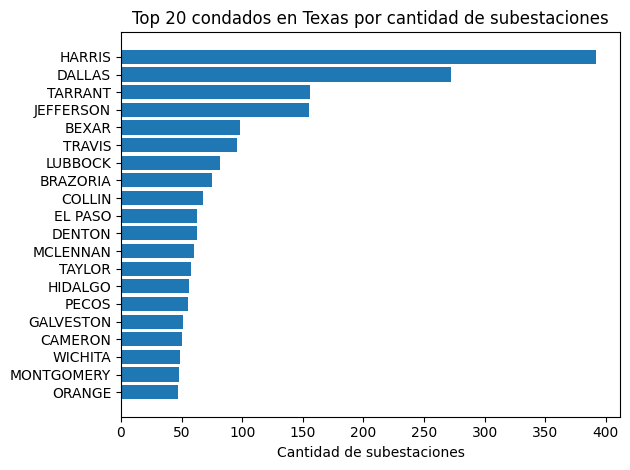

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(top_counties["COUNTY"][::-1], top_counties["n_substations"][::-1])
plt.title("Top 20 condados en Texas por cantidad de subestaciones")
plt.xlabel("Cantidad de subestaciones")
plt.tight_layout()
plt.show()


MAPA SUBESTACIONES

In [11]:
import folium
from folium.plugins import MarkerCluster

# Centro aproximado de Texas
m = folium.Map(location=[31.0, -99.0], zoom_start=6)

cluster = MarkerCluster().add_to(m)

# sample para que no pese
sample_n = min(len(df_sub_tx), 3000)
df_sample = df_sub_tx.sample(sample_n, random_state=42)

for _, row in df_sample.iterrows():
    popup = f"{row.get('NAME','')} - {row.get('CITY','')} ({row.get('COUNTY','')})"
    folium.Marker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        popup=popup
    ).add_to(cluster)

m


GUARDAR RESULTADOS

In [12]:
import os
os.makedirs(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\outputs", exist_ok=True)

top_utils.to_csv(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\outputs\top20_utilities_tx.csv", index=False)
by_type.to_csv(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\outputs\tx_zips_by_utility_type.csv", index=False)
top_counties.to_csv(r"C:\Users\palmi\OneDrive\Escritorio\Bootcamp\texas-utility-capstone\outputs\top20_counties_by_substations.csv", index=False)

print("✅ Guardado en outputs/")


✅ Guardado en outputs/
